In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Oct  6 15:28:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/new/data/train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/new/data/train'.
There are 0 directories and 1337 images in '/content/drive/MyDrive/new/data/train/elephant'.
There are 0 directories and 1273 images in '/content/drive/MyDrive/new/data/train/non_elephant'.


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/new/data/train/"
test_dir = "/content/drive/MyDrive/new/data/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 2610 images belonging to 2 classes.
Testing images:
Found 339 images belonging to 2 classes.


In [ ]:

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=2):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
train_data_10_percent.num_classes

2

In [ ]:
len(train_data_10_percent.classes)

2610

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=10,
                                  # steps_per_epoch=len(train_data_10_percent),
                                  steps_per_epoch=10,
                                  validation_data=test_data,
                                  # validation_steps=len(test_data),
                                  validation_steps=10,
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231006-152907
Epoch 1/10
10/10 [==============================] - 282s 29s/step - loss: 0.5635 - accuracy: 0.7125 - val_loss: 0.2648 - val_accuracy: 0.9156
Epoch 2/10
10/10 [==============================] - 85s 9s/step - loss: 0.2216 - accuracy: 0.9094 - val_loss: 0.1367 - val_accuracy: 0.9625
Epoch 3/10
10/10 [==============================] - 71s 7s/step - loss: 0.1406 - accuracy: 0.9438 - val_loss: 0.0999 - val_accuracy: 0.9688
Epoch 4/10
10/10 [==============================] - 57s 6s/step - loss: 0.1064 - accuracy: 0.9563 - val_loss: 0.0784 - val_accuracy: 0.9844
Epoch 5/10
10/10 [==============================] - 53s 6s/step - loss: 0.1205 - accuracy: 0.9563 - val_loss: 0.0811 - val_accuracy: 0.9781
Epoch 6/10
10/10 [==============================] - 47s 5s/step - loss: 0.1186 - accuracy: 0.9563 - val_loss: 0.0868 - val_accuracy: 0.9844
Epoch 7/10
10/10 [==============================] - 39s 4s/step - loss: 0.0977 - ac

In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

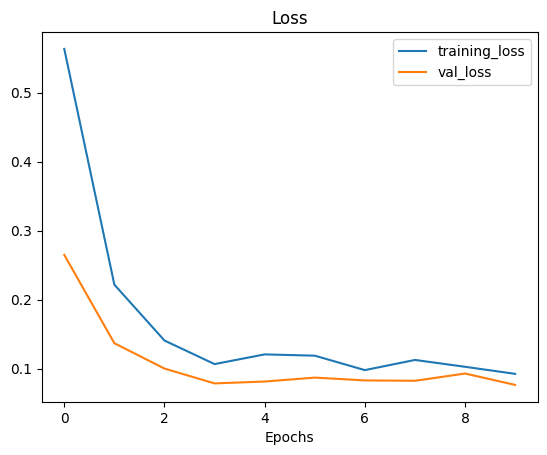

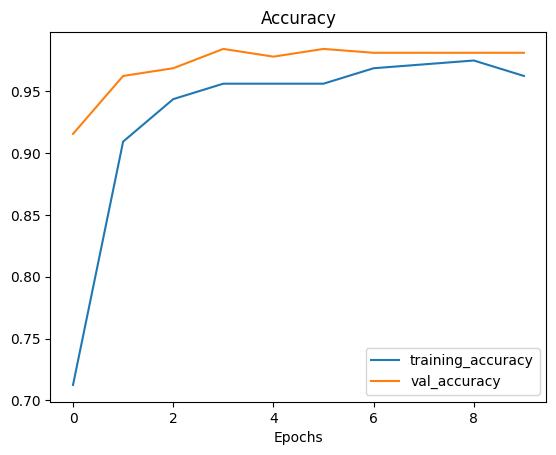

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


**Saving the model**

In [ ]:
tf.keras.models.save_model(resnet_model,'/content/drive/MyDrive/new/resnet_model.h5')

<ipython-input-26-5b0ad69fbe23>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(resnet_model,'/content/drive/MyDrive/new/resnet_model.h5')


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/new/resnet_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/drive/MyDrive/new/data/train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['elephant' 'non_elephant']


In [ ]:
class_names = ['non_elephant','elephant']

1/1 [==============================] - 2s 2s/step


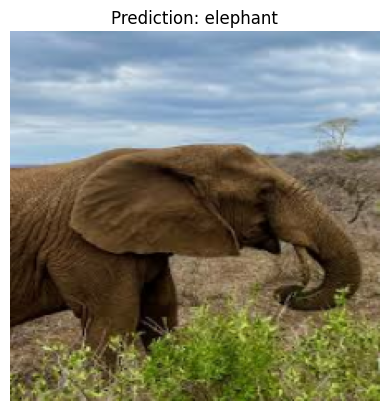

In [ ]:
# Test our model on a custom image

pred_and_plot(new_model, "/content/drive/MyDrive/new/data/test/elephant/af_te12.jpg", class_names)

1/1 [==============================] - 0s 56ms/step


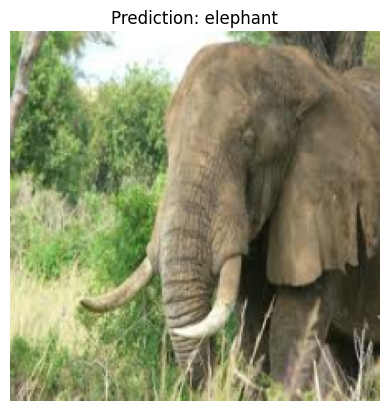

In [ ]:
pred_and_plot(new_model, "/content/drive/MyDrive/new/data/test/elephant/af_te10.jpg", class_names)

1/1 [==============================] - 0s 45ms/step


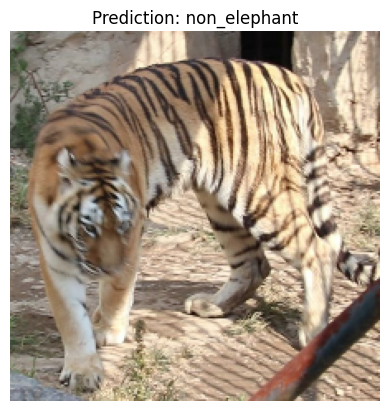

In [ ]:
pred_and_plot(new_model, "/content/drive/MyDrive/new/data/test/non_elephant/000011.jpg", class_names)

1/1 [==============================] - 0s 48ms/step


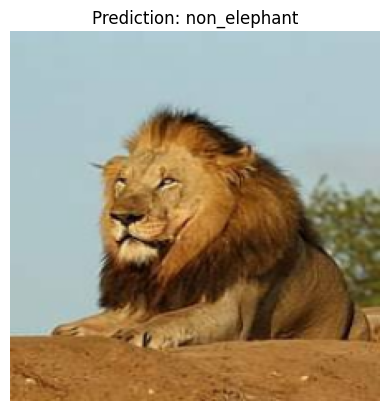

In [ ]:
pred_and_plot(new_model, "/content/drive/MyDrive/new/data/test/non_elephant/96a73103e3.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/buffalo.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/cat.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/content/elephant3.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/content/elephants2.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/content/elephants2.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/content/horse1.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/content/horses2.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/content/lion1.jpg", class_names)

In [ ]:
pred_and_plot(new_model, "/content/water_buffalo_africa_animal_220184.jpg", class_names)